In [2]:
# !pip install numpy pandas matplotlib seaborn scikit-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [4]:
# !pip install openpyxl

In [6]:
df = pd.read_excel("/home/kushal/Documents/projects/tf-idf-implementation/data/ConcatenatedDigitalAdData.xlsx")


In [7]:
df["TitleandDesc"] = df["title"] + df["Job_Description"]

In [8]:
# df

In [9]:
df["TitleandDesc"]

0       Commercial Painters needed ASAP at our Dallas/...
1       Nightclub Jobs -Model/Servers- Cash Daily,Look...
2       Nightclub Jobs -Model Servers- Cash Daily,* Mo...
3       PRINTING - 1st shift,CDL Class A full time loc...
4       Admin Assistant,Necesito personal de limpieza ...
                              ...                        
1536    Price Quoting AnalystElectronics company in Ca...
1537    Conltoller/Office Manager at Exciting CompanyR...
1538    Accounting & Tax ProfessionalCPA firm is hirin...
1539    Licensed Life and Health agenthttps://team.inv...
1540    REMCO NOW HIRING $2,600-$3,000 + COMMISSIONS -...
Name: TitleandDesc, Length: 1541, dtype: object

In [10]:
df
df.drop(['Index', 'title','url','Posted-Date', 'Job_Description'], axis=1, inplace=True)

In [11]:
# df

In [12]:
first_column = df.pop('TitleandDesc')
df.insert(0, 'TitleandDesc', first_column)

In [13]:
df.shape

(1541, 2)

In [14]:
total = df['TitleandDesc'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [15]:
# df.head(15)

In [16]:
pd.DataFrame(df.JobType.unique()).values

array([['Jobs – Retail'],
       ['Jobs – IT'],
       ['Rent – Apartment'],
       ['Sell – House'],
       ['Banking']], dtype=object)

In [17]:
from collections import Counter
Counter(df["JobType"])

Counter({'Jobs – Retail': 517,
         'Jobs – IT': 91,
         'Rent – Apartment': 135,
         'Sell – House': 607,
         'Banking': 191})

In [18]:
df['Job_Id'] = df['JobType'].factorize()[0]
job_id_df = df[['JobType', 'Job_Id']].drop_duplicates()


# Dictionaries for future use
job_to_id = dict(job_id_df.values)
id_to_job = dict(job_id_df[['Job_Id', 'JobType']].values)

# New dataframe
df

,TitleandDesc,JobType,Job_Id
0,Commercial Painters needed ASAP at our Dallas/...,Jobs – Retail,0
1,"Nightclub Jobs -Model/Servers- Cash Daily,Look...",Jobs – Retail,0
2,"Nightclub Jobs -Model Servers- Cash Daily,* Mo...",Jobs – Retail,0
3,"PRINTING - 1st shift,CDL Class A full time loc...",Jobs – IT,1
4,"Admin Assistant,Necesito personal de limpieza ...",Jobs – IT,1
...,...,...,...
1536,Price Quoting AnalystElectronics company in Ca...,Banking,4
1537,Conltoller/Office Manager at Exciting CompanyR...,Banking,4
1538,Accounting & Tax ProfessionalCPA firm is hirin...,Banking,4
1539,Licensed Life and Health agenthttps://team.inv...,Banking,4


In [19]:
df.isnull().sum()

TitleandDesc    0
JobType         0
Job_Id          0
dtype: int64

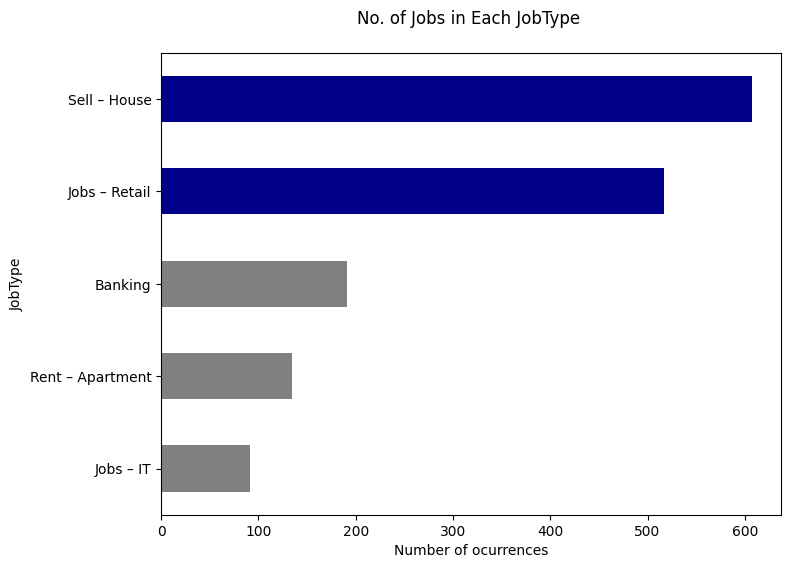

In [20]:
fig = plt.figure(figsize=(8,6))
colors = ['grey', 'grey', 'grey', 'darkblue', 'darkblue']
df.groupby('JobType').TitleandDesc.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'No. of Jobs in Each JobType \n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [21]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df.TitleandDesc).toarray()

labels = df.Job_Id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1541 complaints is represented by 15335 features (TF-IDF score of unigrams and bigrams)


In [22]:
# features

In [23]:
# labels

# Generating Uni and Bigrams

In [24]:
N = 5
for JobType, Job_Id in sorted(job_to_id.items()):
    features_chi2 = chi2(features, labels == Job_Id)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

    print("\n==> %s:" %(JobType))
    
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    print("  * Most Correlated Trigrams are: %s" %(', '.join(trigrams[-N:])))

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [25]:
X = np.array(df["TitleandDesc"])

In [26]:
y = np.array(df["JobType"])

In [27]:
job_types = pd.DataFrame(df.JobType.unique()).values.tolist()


# Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# OneVsRest Classifier
`we can use the OneVsRest classifier concept. The OneVsRest (or one-vs.-all, OvA or OvR, oneagainst-all, OAA) strategy involves training a single classiﬁer per class, with the samples of that class as positive samples and all other samples as negatives. This strategy requires the base classiﬁers to produce a real-valued conﬁdence score for its decision, rather than just a class label; discrete class labels alone can lead to ambiguities, where multiple classes are predicted for a single sample.`

In [29]:
#pipeline of feature engineering and model
model = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])
#the class_weight="balanced" option tries to remove the biasedness of model towards majority sample


# Confusion Matrix

In [30]:
#fit model with training data
model.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced')))])

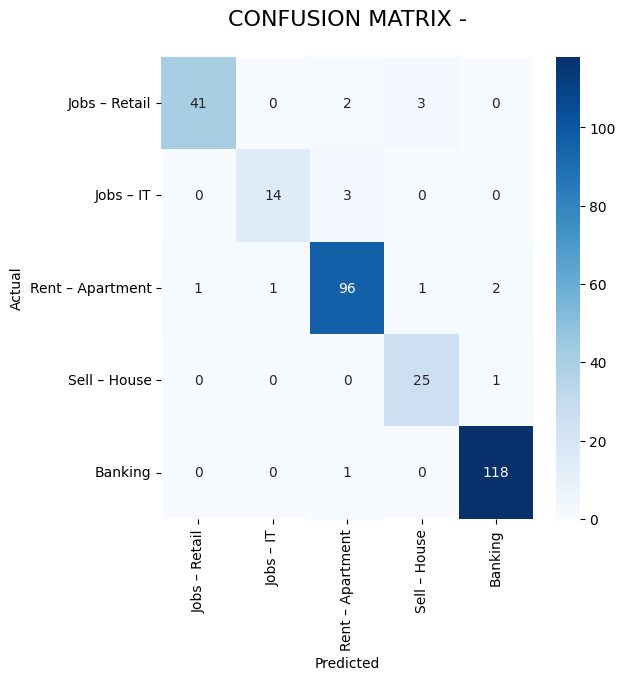

In [31]:
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=job_id_df.JobType.values, 
            yticklabels=job_id_df.JobType.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX -\n", size=16);

In [32]:
# Classification report
print('\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test, y_pred, 
                                    target_names= df['JobType'].unique()))

			CLASSIFICATIION METRICS

                  precision    recall  f1-score   support

   Jobs – Retail       0.98      0.89      0.93        46
       Jobs – IT       0.93      0.82      0.87        17
Rent – Apartment       0.94      0.95      0.95       101
    Sell – House       0.86      0.96      0.91        26
         Banking       0.98      0.99      0.98       119

        accuracy                           0.95       309
       macro avg       0.94      0.92      0.93       309
    weighted avg       0.95      0.95      0.95       309



# Save the model for Later Use

In [34]:
import pickle
filename = '/home/kushal/Documents/projects/tf-idf-implementation/model/adv_model.sav'
# pickle.dump(model, open(filename, 'wb'))

# Load The Model

In [35]:
loaded_model = pickle.load(open(filename, 'rb'))

# Check Accuracy

In [36]:
result = loaded_model.score(X_test, y_test)
print(result)

0.9514563106796117


In [37]:
model.classes_

array(['Banking', 'Jobs – IT', 'Jobs – Retail', 'Rent – Apartment',
       'Sell – House'], dtype='<U16')

# Sample Input and Testing The Model

In [38]:
job = input()
print(job)
model.predict([job])[0]

/home/kushal/Documents/projects/tf-idf-implementation/model


'Sell – House'